In [1116]:
import pandas as pd
import numpy as np
import sklearn.metrics
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
from sklearn.cluster import MeanShift

from sklearn.decomposition import PCA

In [1117]:
make_rounding = lambda num: format(num, '.2f')

# Задание 1

In [1118]:
def prepare_num(df):

    not_numeric = df.columns[df.dtypes.ne("int64") & df.dtypes.ne("float64")]
    df_num = df.drop(not_numeric, axis = 1)

    for colm in not_numeric:
        new_df = pd.get_dummies(df[colm], prefix = colm)
        df_num = pd.concat((df_num, new_df), axis = 1)
        
    df_num = df_num.fillna(df_num.median())

    return df_num

In [1119]:
df_main = pd.read_csv('train.csv')

df_prep_x = df_main.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)
df_prep_x = prepare_num(df_prep_x)
df_prep_x = shuffle(df_prep_x)

split = lambda df: np.split(df, [int(0.8 * len(df)), int(0.9 * len(df))])

df_train_y, df_test_y, df_val_y = split(df_prep_x['Survived'])
df_prep_x = df_prep_x.drop(['Survived'], axis = 1)

df_train_x, df_test_x, df_val_x = split(df_prep_x)


c:\Users\Sanya\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\shape_base.py:790: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sub_arys.append(_nx.swapaxes(sary[st:end], axis, 0))


### Random Forest

In [1120]:
best_forest_est = 0
best_forest_depth = 0
best_forest_criterion = ''

max_acc = 0

for n_estimators in range(1, 15):
    for max_depth in range(1, 15):
        for criterion in ['gini', 'entropy', 'log_loss']:

            model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, criterion = criterion)
            model.fit(df_train_x, df_train_y)
            predict = model.predict(df_val_x)

            cur_acc = sklearn.metrics.accuracy_score(df_val_y, predict)

            if cur_acc > max_acc:
                max_acc = cur_acc

                best_forest_est = n_estimators
                best_forest_depth = max_depth
                best_forest_criterion = criterion

model_forest = RandomForestClassifier(n_estimators = best_forest_est, max_depth = best_forest_depth, criterion = best_forest_criterion)
model_forest.fit(df_train_x, df_train_y)
predict = model_forest.predict(df_test_x)

print('n_estimators =', best_forest_est)
print('max_depth =', best_forest_depth)
print('criterion =', best_forest_criterion)
print('accuracy =', make_rounding(sklearn.metrics.accuracy_score(df_test_y, predict)))


n_estimators = 1
max_depth = 9
criterion = gini
accuracy = 0.85


#### XGBoost

In [1121]:
def find_xgb_params(df_train_x, df_train_y, df_val_x, df_val_y):

    best_est = 0
    best_depth = 0

    max_acc = 0

    for n_estimators in range(1, 30):
        for max_depth in range(1, 10):

            model = XGBClassifier(n_estimators = n_estimators, max_depth = max_depth)
            model.fit(df_train_x, df_train_y)
            predict = model.predict(df_val_x)

            cur_acc = sklearn.metrics.accuracy_score(df_val_y, predict)

            if cur_acc > max_acc:
                max_acc = cur_acc

                best_est = n_estimators
                best_depth = max_depth

    return max_acc, best_est, best_depth

In [1122]:
_, best_est, best_depth = find_xgb_params(df_train_x, df_train_y, df_val_x, df_val_y)

model = XGBClassifier(n_estimators = best_est, max_depth = best_depth)
model.fit(df_train_x, df_train_y) 
predict = model.predict(df_test_x)

print('n_estimators =', best_est)
print('max_depth =', best_depth)
print('accuracy =', make_rounding(sklearn.metrics.accuracy_score(df_test_y, predict)))

n_estimators = 1
max_depth = 9
accuracy = 0.87


#### Logistic Regression

In [1123]:
def find_logReg_params(df_train_x, df_train_y, df_val_x, df_val_y):

    best_solver = ''
    max_acc = 0

    for solver in ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']:

        model = LogisticRegression(solver = solver)
        model.fit(df_train_x, df_train_y)
        predict = model.predict(df_val_x)

        cur_acc = sklearn.metrics.accuracy_score(df_val_y, predict)

        if cur_acc > max_acc:
            max_acc = cur_acc
            best_solver = solver

    return max_acc, best_solver


In [1124]:
scaler = MinMaxScaler()
scaled_x_train = scaler.fit_transform(df_train_x)
scaled_x_tst = scaler.transform(df_test_x)
scaled_x_val = scaler.transform(df_val_x)

_, best_solver = find_logReg_params(scaled_x_train, df_train_y, scaled_x_val, df_val_y)

model = LogisticRegression(solver = best_solver)
model.fit(scaled_x_train, df_train_y)
predict = model.predict(scaled_x_tst)

print('solver =', best_solver)
print('accuracy =', make_rounding(sklearn.metrics.accuracy_score(df_test_y, predict)))

solver = lbfgs
accuracy = 0.89


#### KNN

In [1125]:
best_n_neighbors = 0
max_acc = 0

for n_neighbors in range(2, 30):
            
    model = KNeighborsClassifier(n_neighbors = n_neighbors)
    model.fit(df_train_x, df_train_y)
    predict = model.predict(df_val_x)

    cur_acc = sklearn.metrics.accuracy_score(df_val_y, predict)

    if cur_acc > max_acc:
        max_acc = cur_acc
        best_n_neighbors = n_neighbors

model = KNeighborsClassifier(n_neighbors = n_neighbors)
model.fit(df_train_x, df_train_y)
predict = model.predict(df_test_x)

print('n_neighbors =', best_n_neighbors)
print('accuracy =', make_rounding(sklearn.metrics.accuracy_score(df_test_y, predict)))

n_neighbors = 2
accuracy = 0.78


# Задание 2

In [1126]:
def take_features(cnt, df_prep_x, df_prep_y, indices):

    features = df_prep_x.columns
    df = pd.DataFrame()

    for i in range(1, cnt + 1):
        df = pd.concat((df, df_prep_x[features[indices[-i]]]), axis = 1)

    return train_test_split(df, df_prep_y, train_size = 0.9)

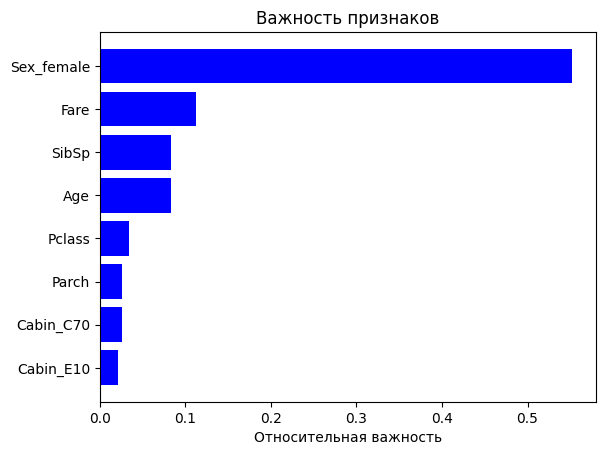

Accuracy for 2 features: 0.72
Accuracy for 4 features: 0.72
Accuracy for 8 features: 0.80


In [1127]:
df_prep_x = df_main.drop(['PassengerId', 'Name', 'Ticket'], axis = 1)
df_prep_x = prepare_num(df_prep_x)

survived = df_prep_x['Survived']
df_prep_x = df_prep_x.drop(['Survived'], axis = 1)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_prep_x, survived, train_size = 0.9)

importances = model_forest.feature_importances_
features = df_prep_x.columns

indices = np.argsort(importances)[-8:]

plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color = 'b', align = 'center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительная важность')
plt.show()

for i in [2, 4, 8]:

    df_train_x, df_test_x, df_train_y, df_test_y = take_features(i, df_prep_x, survived, indices)

    model = RandomForestClassifier(n_estimators = best_forest_est, max_depth = best_forest_depth, criterion = best_forest_criterion)
    model.fit(df_train_x, df_train_y)
    predict = model.predict(df_test_x)

    print("Accuracy for", i, "features:", make_rounding(sklearn.metrics.accuracy_score(df_test_y, predict)))


# Задание 3

In [1128]:
def make_plt(clusters):

    plt.figure(figsize = (6, 6))
    
    for cl in np.unique(clusters):
        data_ = df_main[clusters == cl]
        plt.scatter(data_[:, 0], data_[:, 1])

    plt.ylabel('Longitude')
    plt.xlabel('Latitude')

### KMeans

c:\Users\Sanya\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


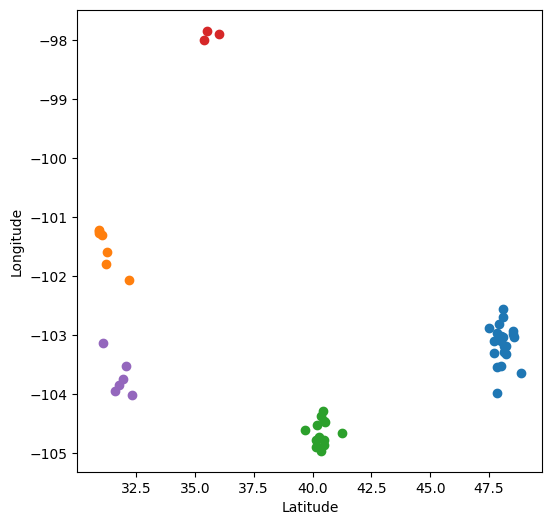

In [1129]:
df_main = np.array(pd.read_csv('wells_info.csv', usecols = ['BottomHoleLatitude', 'BottomHoleLongitude']))

model = KMeans(n_clusters = 5)
clusters = model.fit_predict(df_main)

make_plt(clusters)
plt.show()

### DBSCAN

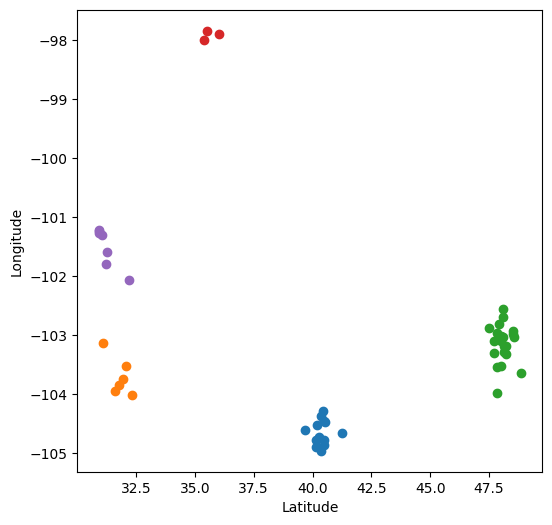

In [1130]:
model = DBSCAN(eps = 1, min_samples = 1)
clusters = model.fit_predict(df_main)

make_plt(clusters)
plt.show()

### BIRCH

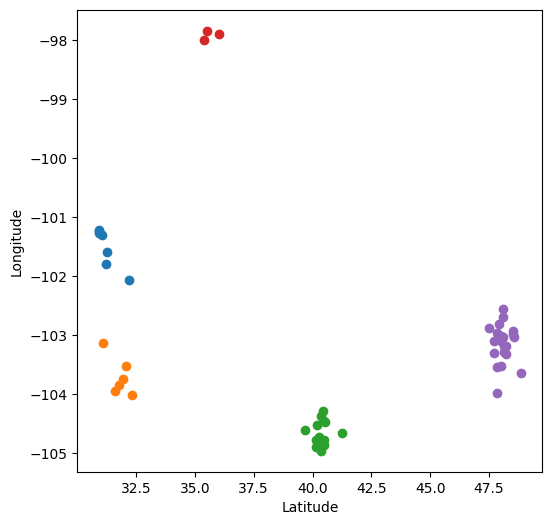

In [1131]:
model = Birch(n_clusters = 5)
clusters = model.fit_predict(df_main)

make_plt(clusters)
plt.show()

### MeanShift

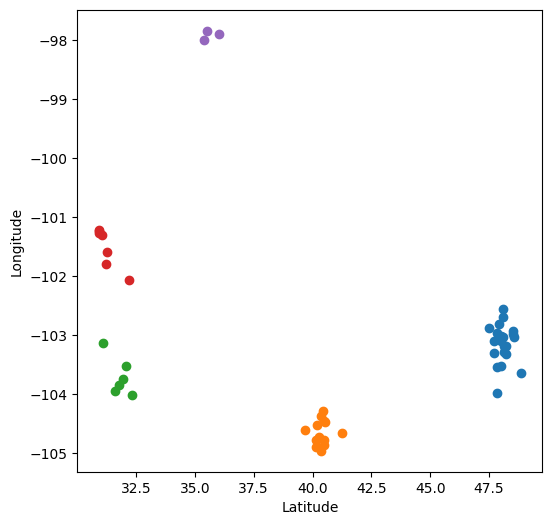

In [1132]:
model = MeanShift(bandwidth = 1)
clusters = model.fit_predict(df_main)

make_plt(clusters)
plt.show()

# Задание 4

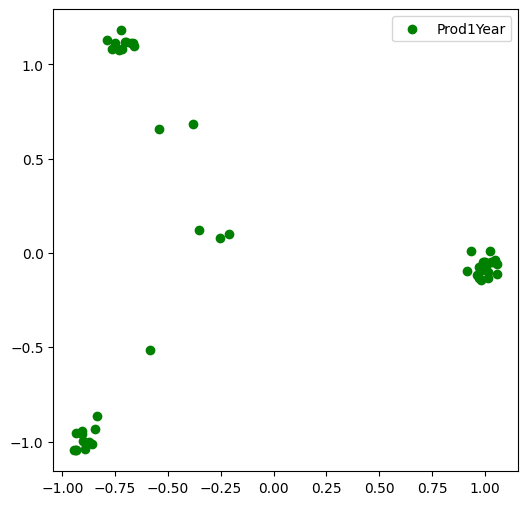

In [1133]:
df_prep_x = pd.read_csv('wells_info_with_prod.csv', usecols = ['PermitDate', 'CompletionDate', 'FirstProductionDate', 'StateName', 'BasinName', 'Prod1Year'])

df_prep_x = prepare_num(df_prep_x)
df_prep_x = scaler.fit_transform(df_prep_x)

model = PCA(n_components = 2)
squeezed = model.fit_transform(df_prep_x)

plt.figure(figsize = (6, 6))
plt.scatter(squeezed[:][:, 0], squeezed[:][:, 1], color = 'green')

plt.legend()
plt.show()

# Лабораторная 9.1

Decision Tree accuracy: 0.89
XGBoost accuracy: 0.89
Logistic Regression accuracy: 0.87


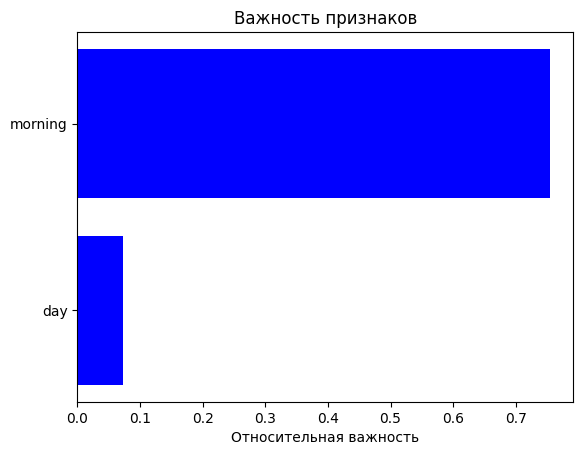

Accuracy for 2 features: 0.88


In [1134]:
df_main = pd.read_csv('titanic_prepared.csv', index_col = 0)
df_label = df_main['label']
df_main = df_main.drop(['label'], axis = 1)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_main, df_label, train_size = 0.9)

max_acc = 0
best_depth, best_criterion = 0, ''
best_model = None
for depth in range(1, 15):
    for criterion in ["gini", "entropy", "log_loss"]:

        model = DecisionTreeClassifier(max_depth = depth, criterion = criterion)
        model.fit(df_train_x, df_train_y)

        predict = model.predict(df_test_x)
        cur_acc = sklearn.metrics.accuracy_score(df_test_y, predict)

        if cur_acc > max_acc:
            max_acc = cur_acc

            best_depth = depth
            best_criterion = criterion
            best_model = model

print("Decision Tree accuracy:", make_rounding(max_acc))

max_acc = find_xgb_params(df_train_x, df_train_y, df_test_x, df_test_y)[0]
print("XGBoost accuracy:", make_rounding(max_acc))

scaled_x_train = scaler.fit_transform(df_train_x)
scaled_x_tst = scaler.transform(df_test_x)

max_acc = find_logReg_params(scaled_x_train, df_train_y, scaled_x_tst, df_test_y)[0]
print("Logistic Regression accuracy:", make_rounding(max_acc))

importances = best_model.feature_importances_
features = df_main.columns

indices = np.argsort(importances)[-2:]

plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color = 'b', align = 'center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительная важность')
plt.show()

df_train_x, df_test_x, df_train_y, df_test_y = take_features(2, df_main, df_label, indices)

best_model.fit(df_train_x, df_train_y)
predict = best_model.predict(df_test_x)

print("Accuracy for 2 features:", make_rounding(sklearn.metrics.accuracy_score(df_test_y, predict)))
